# Forecasting Coffee Price

<big><font color="grey"><b>Aksana Lefter</b></font></big>

Coffee is a beverage consisting of a decoction or infusion of the roasted ground or crushed seeds (coffee beans ) of the two-seeded fruit (coffee berry ) of certain coffee trees.[1] 

Coffee traces its origin to a genus of plants known as Coffea.  Within the genus there are over 500 genera and 6,000 species of tropical trees and shrubs. In the commercial coffee industry, there are two important coffee species — Arabica and Robusta. 

Coffea Arabica is descended from the original coffee trees discovered in Ethiopia.  These trees produce a fine, mild, aromatic coffee and represent approximately 70% of the world's coffee production. The beans are flatter and more elongated than Robusta and lower in caffeine. Arabica trees are costly to cultivate because the ideal terrain tends to be steep and access is difficult. Also, because the trees are more disease-prone than Robusta, they require additional care and attention.

Most of the world's Robusta is grown in Central and Western Africa, parts of Southeast Asia, including Indonesia and Vietnam, and in Brazil. Production of Robusta is increasing, though it accounts for only about 30% of the world market. The Robusta tree is heartier and more resistant to disease and parasites, which makes it easier and cheaper to cultivate. [2] 

Our task will be to create a model that predicts coffee prices.

## Data analysis

Loading data and libraries.

In [2]:
# Library installation
!pip install pandas -q
!pip install numpy  -q
!pip install matplotlib -q
!pip install seaborn -q
!pip install gdown -q
!pip install plotly -q
!pip install prophet -q
!pip install pmdarima -q
!pip install scikit-learn -q
!pip install tensorflow

In [3]:
# Library import
import gdown
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import math
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

In [367]:
# Load data first 7 lines
try:
    data = pd.read_csv("coffee.csv")
    print("uploaded locally")
except:
    file_id = '1ky5BUPI5thX3LuPPyb135hEFJtHsoIAa'
    url = f'https://drive.google.com/uc?id={file_id}'
    output = 'coffee_name.csv'
    gdown.download(url, output, quiet=False)
    data = pd.read_csv(output)
    print("data download")
data.head(7)

Downloading...
From: https://drive.google.com/uc?id=1ky5BUPI5thX3LuPPyb135hEFJtHsoIAa
To: /home/wsuser/work/coffee_name.csv
100%|██████████| 254k/254k [00:00<00:00, 13.3MB/s]

data download


,Date,Open,High,Low,Close,Volume,Currency
0,2000-01-03,122.25,124.00,116.10,116.50,6640,USD
1,2000-01-04,116.25,120.50,115.75,116.25,5492,USD
2,2000-01-05,115.00,121.00,115.00,118.60,6165,USD
3,2000-01-06,119.00,121.40,116.50,116.85,5094,USD
4,2000-01-07,117.25,117.75,113.80,114.15,6855,USD
5,2000-01-10,123.50,126.00,116.70,117.55,7499,USD
6,2000-01-11,115.50,118.25,115.50,117.80,3976,USD


Let's check the data for monotonicity.

In [125]:
is_date_monotonic = data['Date'].is_monotonic
print(f"The 'Date' column is monotone: {is_date_monotonic}")

The 'Date' column is monotone: True


In the 'Date' column, we'll change the data type to datetime.

In [368]:
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
data

,Open,High,Low,Close,Volume,Currency
Date,,,,,,
2000-01-03,122.25,124.00,116.10,116.50,6640,USD
2000-01-04,116.25,120.50,115.75,116.25,5492,USD
2000-01-05,115.00,121.00,115.00,118.60,6165,USD
2000-01-06,119.00,121.40,116.50,116.85,5094,USD
2000-01-07,117.25,117.75,113.80,114.15,6855,USD
...,...,...,...,...,...,...
2022-08-29,240.55,240.55,240.55,240.50,1,USD
2022-08-30,238.75,241.75,238.75,239.15,14,USD
2022-08-31,240.75,240.75,239.65,239.10,12,USD


Let's start visualization. Let's take a look at the price of coffee.

In [127]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=data.index, y=data['Close'], mode='lines', name='Price', line=dict(color='blue')))

fig.update_layout(title='Daily Coffee Price',
                  xaxis_title='Date',
                  yaxis_title='Price',
                  width=1000,
                  height=500)

fig.show()

So, we see that the price of coffee has increased in 2011. A drop in supplies of high-grade arabica coffee beans and a growing taste for upmarket coffee among the middle classes of China, Brazil, Indonesia and India are blamed for the sharp rise. Continuing weakness in the dollar has also kept many commodity markets soaring and encouraged a buy-up of arabica beans.[3] We could also see coffee prices rise in 2021 and 2022. This increase is due to a combination of drought and frost in Brazil, which some attribute to climate change, has led to them producing far less coffee in 2021 and 2022, resulting in the lowest global coffee reserves in over twenty years. [4]

Now let's get to the modeling. Let's try to use several models (Arima Sarimax, Prophet, and LSTM) to predict the price of coffee. We will determine the best model to predict future prices. We will use the RMSE and MAE metrics to compare the results of the models.

Mean Absolute Error (MAE): MAE measures the average magnitude of the errors in a set of predictions, without considering their direction. It’s the average over the test sample of the absolute differences between prediction and actual observation where all individual differences have equal weight.[5]

Root mean squared error (RMSE): RMSE is a quadratic scoring rule that also measures the average magnitude of the error. It’s the square root of the average of squared differences between prediction and actual observation.[5]


## Modeling

### Arima Sarimax

An autoregressive integrated moving average model is a form of regression analysis that gauges the strength of one dependent variable relative to other changing variables. ARIMA forecasting is achieved by plugging in time series data for the variable of interest.[6]

We will use the Auto ARIMA model to automatically select the optimal parameters. Auto_arima allows selecting the right combination that will make the rows stationary.

In [128]:
model = pm.auto_arima(data['Close'], 
                      start_p = 0, start_q = 0,
                      test = 'kpss',       
                      max_order=1,
                      d = None,          
                      seasonal = True,   
                      trace = True,
                      error_action = 'ignore',  
                      suppress_warnings = True, 
                      stepwise = True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=28460.684, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=28461.928, Time=0.27 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=28461.895, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=28458.947, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=28463.991, Time=0.98 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.694 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 5746
Model:               SARIMAX(0, 1, 0)   Log Likelihood              -14228.473
Date:                Sun, 22 Oct 2023   AIC                          28458.947
Time:                        17:21:20   BIC                          28465.603
Sample:                             0   HQIC                         28461.263
                               - 5746                                  

We split the data into training and test samples.

In [149]:
df = data['Close'].to_frame()
train = df[len(df)-365:len(df)-25]
test = df[len(df)-25:]

Let's train the model and see the results. 

In [150]:
arima_model = SARIMAX(train, order = (0,1,0))
arima_result = arima_model.fit()
arima_pred = arima_result.forecast(steps = 25, index = test.index).rename('ARIMA Predictions')
test['ARIMA_Predictions'] = arima_pred.values
test

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.96115D+00    |proj g|=  6.24139D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      4      1     0     0   1.509D-07   2.961D+00
  F =   2.9611440995873273     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


,Close,ARIMA_Predictions
Date,,
2022-08-01,213.20,217.2
2022-08-02,209.90,217.2
2022-08-03,214.65,217.2
2022-08-04,219.30,217.2
2022-08-05,209.45,217.2
2022-08-08,211.85,217.2
2022-08-09,212.75,217.2
2022-08-10,220.45,217.2
2022-08-11,223.95,217.2


Text(0, 0.5, 'Price')

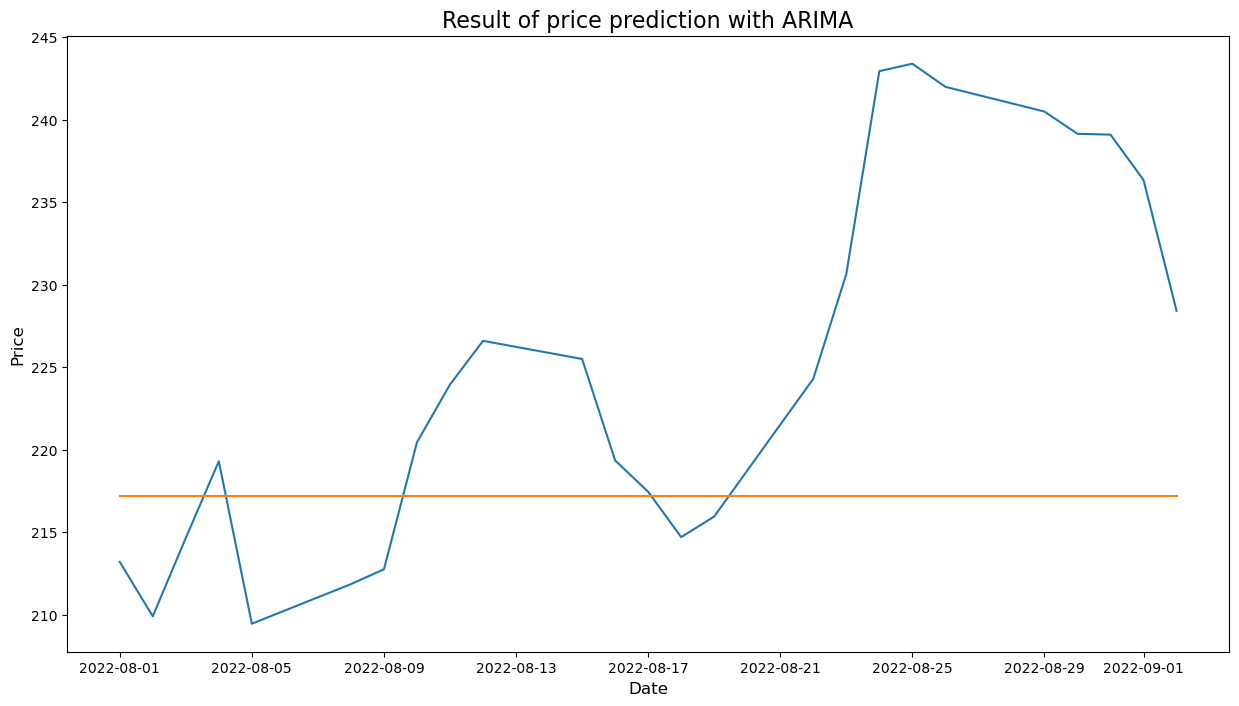

In [151]:
plt.figure(figsize=(15, 8))
plt.title('Result of price prediction with ARIMA', size=16)
plt.plot(test[['Close','ARIMA_Predictions']])
plt.xlabel('Date', size=12)
plt.ylabel('Price', size=12)

In [152]:
print("Root mean square error (RMSE) :", np.sqrt(mean_squared_error(test.Close, test.ARIMA_Predictions)))
print("\nMean absolute error(MAE):", mean_absolute_error(test.Close, test.ARIMA_Predictions))

Root mean square error (RMSE) : 13.575464485607855

Mean absolute error(MAE): 10.486800000000002


The RMSE and MAE results are not bad, but the prediction produced the same result everywhere. Looking at the graph, the Arima Sarimax model does not predict peaks very well.

## Prophet

FBProphet is a forecasting algorithm developed by Facebook’s data science team in 2017. The algorithm is designed to be scalable, fast, and accurate, making it suitable for a wide range of applications, from predicting sales in e-commerce to forecasting weather patterns. The core idea behind FBProphet is to model time series data as a combination of trend, seasonality, and noise components. By decomposing the data into these components, the algorithm can generate accurate forecasts that capture the underlying patterns in the data.[7]

Let's rename the columns to ds and y.

In [419]:
data_prophet = pd.DataFrame(data['Close'])
data_prophet = data_prophet.reset_index()
data_prophet.columns = ['ds','y'] 
data_prophet.head(7)

,ds,y
0,2000-01-03,116.50
1,2000-01-04,116.25
2,2000-01-05,118.60
3,2000-01-06,116.85
4,2000-01-07,114.15
5,2000-01-10,117.55
6,2000-01-11,117.80


We divide the data into test and training samples.

In [420]:
train_prophet = data_prophet.iloc[len(data_prophet)-365:len(data_prophet)-25]
test_prophet = data_prophet.iloc[len(data_prophet)-25:]

Let's check how our samples are divided.

In [421]:
train_prophet

,ds,y
5381,2021-03-25,126.60
5382,2021-03-26,128.50
5383,2021-03-29,127.05
5384,2021-03-30,122.60
5385,2021-03-31,123.50
...,...,...
5716,2022-07-25,210.05
5717,2022-07-26,213.20
5718,2022-07-27,219.10
5719,2022-07-28,218.40


In [422]:
test_prophet

,ds,y
5721,2022-08-01,213.20
5722,2022-08-02,209.90
5723,2022-08-03,214.65
5724,2022-08-04,219.30
5725,2022-08-05,209.45
5726,2022-08-08,211.85
5727,2022-08-09,212.75
5728,2022-08-10,220.45
5729,2022-08-11,223.95
5730,2022-08-12,226.60


Samples are devided well. The test sample will contain data with the period from 01.08.2022 - 02.09.2022. Now let's move on to the Prophet results.

20:46:37 - cmdstanpy - INFO - Chain [1] start processing
20:46:37 - cmdstanpy - INFO - Chain [1] done processing


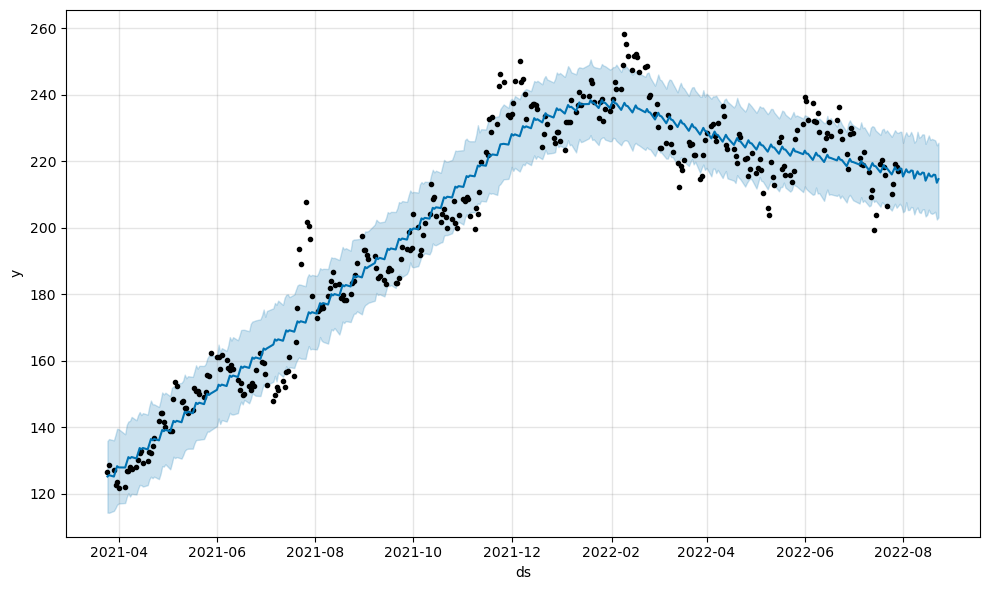

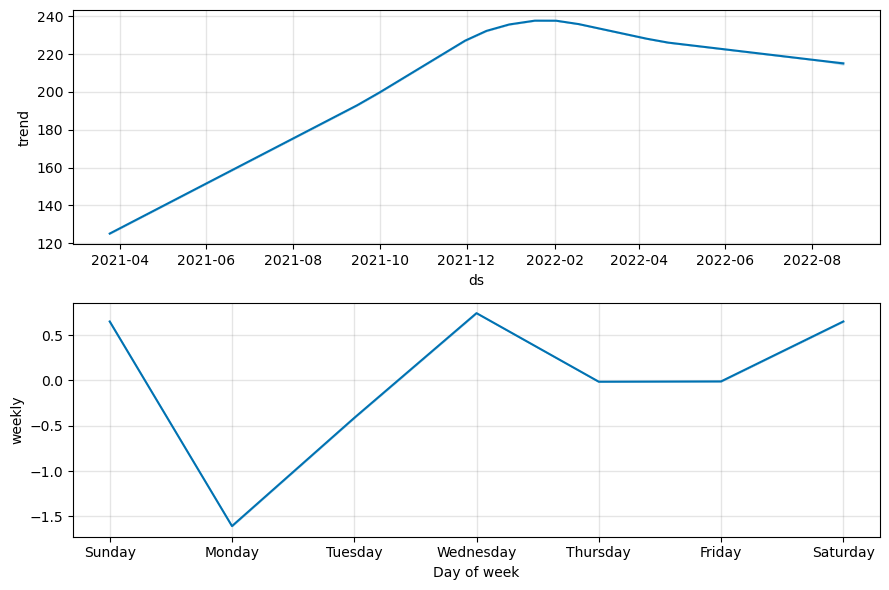

In [426]:
model_season = Prophet()
model_season.fit(train_prophet)
future_season = model_season.make_future_dataframe(periods=25)
forecast_season = model_season.predict(future_season)
model_season.plot(forecast_season)
model_season.plot_components(forecast_season)
season = pd.merge(test_prophet, forecast_season[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-25:], on='ds')

In [427]:
print("Root mean square error (RMSE) :", np.sqrt(mean_squared_error(p_base.y, p_base.yhat)))
print("\nMean absolute error (MAE):", mean_absolute_error(p_base.y, p_base.yhat))

Root mean square error (RMSE) : 15.218356656047401

Mean absolute error (MAE): 11.60269952943233


Prophet has slightly worse results than Arima Sarimax, but Prophet is better at predicting peaks, as you can see in the graph.

## LSTM

LSTM (Long Short-Term Memory) is a recurrent neural network (RNN) architecture widely used in Deep Learning. It excels at capturing long-term dependencies, making it ideal for sequence prediction tasks.

Unlike traditional neural networks, LSTM incorporates feedback connections, allowing it to process entire sequences of data, not just individual data points. This makes it highly effective in understanding and predicting patterns in sequential data like time series, text, and speech.[8]

We will prepare the data and train the model.

In [369]:
lstm = data.iloc[-365:]

In [370]:
close_prices = lstm['Close']
values = close_prices.values
training_data_len = 340

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))

train_data = scaled_data[0: training_data_len, :]

X_train = []
y_train = []

for i in range(60, len(train_data)):
    X_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [371]:
test_data = scaled_data[training_data_len-60: , : ]
X_test = []
y_test = values[training_data_len:]

for i in range(60, len(test_data)):
  X_test.append(test_data[i-60:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [372]:
tf.random.set_seed(2)
model = keras.Sequential()
model.add(layers.LSTM(90, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(layers.LSTM(60, return_sequences=False))
model.add(layers.Dense(25))
model.add(layers.Dense(1))
model.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_50 (LSTM)              (None, 60, 90)            33120     
                                                                 
 lstm_51 (LSTM)              (None, 60)                36240     
                                                                 
 dense_53 (Dense)            (None, 25)                1525      
                                                                 
 dense_54 (Dense)            (None, 1)                 26        
                                                                 
Total params: 70,911
Trainable params: 70,911
Non-trainable params: 0
_________________________________________________________________


In [373]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size= 1, epochs=7)

Epoch 1/7
280/280 [==============================] - 9s 25ms/step - loss: 0.0130
Epoch 2/7
280/280 [==============================] - 7s 26ms/step - loss: 0.0051
Epoch 3/7
280/280 [==============================] - 8s 27ms/step - loss: 0.0047
Epoch 4/7
280/280 [==============================] - 7s 24ms/step - loss: 0.0037
Epoch 5/7
280/280 [==============================] - 7s 26ms/step - loss: 0.0034
Epoch 6/7
280/280 [==============================] - 7s 25ms/step - loss: 0.0033
Epoch 7/7
280/280 [==============================] - 7s 24ms/step - loss: 0.0032


In [347]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

1/1 [==============================] - 1s 555ms/step


In [348]:
print("Root mean square error (RMSE) :", np.sqrt(mean_squared_error(y_test, predictions)))
print("\nMean absolute error (MAE):", mean_absolute_error(y_test, predictions))

Root mean square error (RMSE) : 6.537015411743434

Mean absolute error (MAE): 5.075705493164065


Visualizing the results.

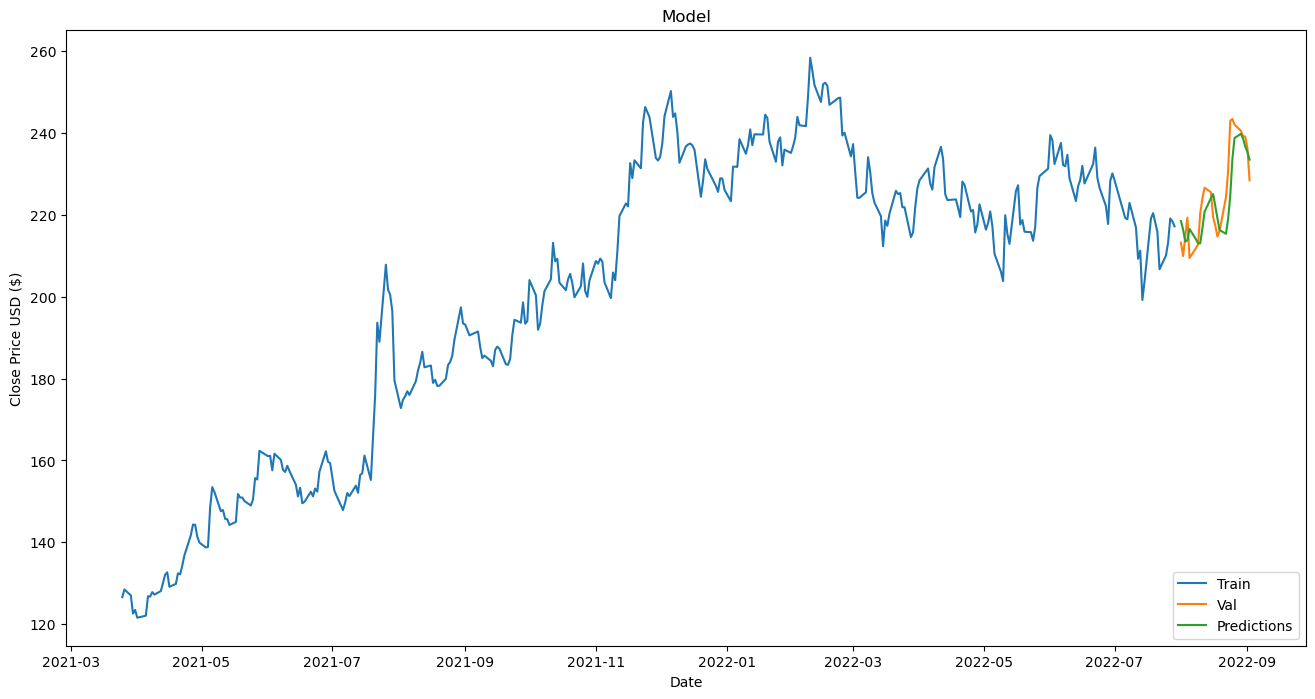

In [349]:
data = lstm.filter(['Close'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

According to the above graph and MAE and RMSE results, the LSTM model performed better.

## Conclusion

To summarize, the best results came from the LSTM model. The MAE and RMSE metrics of the LSTM model were better than those of Arima and Prophet. It should be noted that weather conditions significantly affect the price of coffee. Perhaps if additional weather parameters were provided, the forecast could be more accurate.

## List of sources

1 - https://www.dictionary.com/browse/coffee

2 - https://www.ncausa.org/About-Coffee/What-is-Coffee

3 - https://www.cbsnews.com/news/coffee-prices-highest-in-34-years/

4 - https://ritualcoffee.com/news/rise-in-coffee-prices/

5 - https://medium.com/human-in-a-machine-world/mae-and-rmse-which-metric-is-better-e60ac3bde13d

6 - https://www.investopedia.com/terms/a/autoregressive-integrated-moving-average-arima.asp

7 - https://medium.com/illumination/understanding-fb-prophet-a-time-series-forecasting-algorithm-c998bc52ca10

8 - https://www.analyticsvidhya.com/blog/2021/03/introduction-to-long-short-term-memory-lstm/